In [3]:
# imports here!

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cmath
PI = np.pi                                  #### IMPORTANT : initialising PI as np.pi
exp = np.e                                  #### IMPORTANT : initialising exp as np.e

# Homework -03
## K.Surya Prakash
## EE18BTECH11026

###  Class to plot images 

In [4]:
class image:                                             ## class for an image .. provides histogram, thresholding
    def __init__(self,path = None,img = None,plot = False,title = None):
        if(path!=None):
            self.img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        else :
            self.img = img
        self.h,self.w = np.shape(self.img)
        
        if(plot == 1):
            plt.title(title)
            plt.imshow(self.img,cmap = 'gray')
            plt.plot()
            plt.figure()
            
    
            
            

## Problem-01 Motion estimation

### Setup

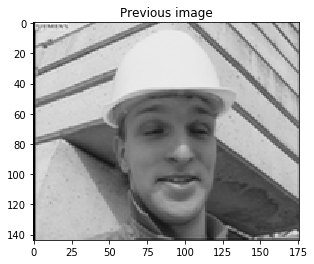

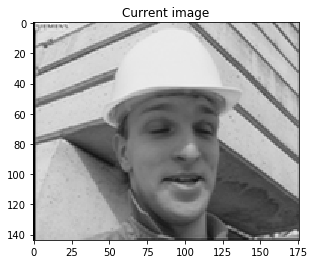

<Figure size 432x288 with 0 Axes>

In [5]:
img1 = image(path = 'first_frame.png',plot = True,title = 'Previous image')
Prev = img1.img   ### P --> Previous
img2 = image(path = 'second_frame.png',plot = True,title = 'Current image')
Curr = img2.img   ### C --> current

## All Codes here !!

In [6]:

######################################
####    Code for 1.1
######################################


### This transforms the image into macro block pieces.
### i.e;  144*176 ---> 9*11*256   256 is a vector containing the elments of the macroblock 
def create_MB_matrix(I,size):  ### Size = size of block = 16
    M,N = I.shape
    m,n = int(M/size), int(N/size)
    MB = np.zeros((m,n,size**2))
    temp = np.zeros((size,size))
    for i in range(m):
        for j in range(n):
            temp = I[i*size:(i+1)*size,j*size:(j+1)*size]
            
            T = temp.reshape((size*size,))
            MB[i][j] = T
    return MB


def MAD(v1,v2):         ### This function resuts the mad of indices of the MB_matrix. i.e return  sum(|v1 - v2|)
    v = np.mean(abs(v1-v2))  ### Returns the mean absolute difference of both 256 vectors
    return v

### Checks if the block to be searhed exists fully .. To avoid boundary cases
def valid(Prev,index_pair,size):
    i,j = index_pair
    if(i-7 >-1 and i+8 < Prev.shape[0] and j-7 >-1 and j+8 < Prev.shape[1] ):
        return True
    return False


### Extracts the elements in a window whose center is the index_pair
def extract_block(Prev,index_pair,size):
    ic,jc = int(index_pair[0]),int(index_pair[1])
    Blk = np.zeros((size,size))
    Blk = Prev[ic-7:ic+9 , jc-7:jc+9]
    
    return Blk
    
## This is for searching over a neighbourhood with a given step value
## A max of 9 blocks are searched
def mini_search(v,Prev,index_pair,s,size):   ### v --> block  s-->step
    i,j = index_pair
    steps = np.array([[i,j],[i+s,j+s],[i-s,j+s],[i+s,j-s],[i-s,j-s],[i+s,j],[i-s,j],[i,j+s],[i,j-s]])
    mini = 10000
    for k in steps:
        if(valid(Prev,k,size)):
            temp = extract_block(Prev,k,size)
            t_v = temp.reshape((size*size,))
            
            diff = MAD(v,t_v)
            if(diff < mini):
                mini  = diff
                ans = k
    return ans
    
    
def search(v,Prev,ic,jc,size):  ### 3stage search
    index = np.array([ic,jc])
    s1 = mini_search(v,Prev,index,4,size)  ## Stage :01
    s2 = mini_search(v,Prev,s1,2,size)     ## Stage :02
    s3 = mini_search(v,Prev,s2,1,size)     ## Stage :03
    return s3
    
def create_MV(Prev,MB,size):  ### Creates the motion vector of the form (9*11*2))
    M,N = Prev.shape        
    m,n = int(M/size), int(N/size)
    MV = np.zeros((m,n,2))
    MV_rel = np.zeros((m,n,2))
    
    for i in range(m):
        for j in range(n):
            ic = i*size + 7
            jc = j*size + 7   ### Pixel indices of center of the block
            
            MV[i][j] = search(MB[i][j],Prev,ic,jc,size) 
            MV_rel[i][j] = search(MB[i][j],Prev,ic,jc,size)  - np.array([ic,jc])
    return MV,MV_rel
    
    
######################################
####    Code for 1.2
######################################  

### This plots the Motion vector on the current image 
    
def plot_MV(Curr,MV,size,title):
    plt.imshow(Curr,cmap = 'gray')
    m,n,_ = MV.shape
    for i in range(m):
        for j in range(n):
            plt.arrow(j*size + (size*0.5),
                      i*size + (size*0.5),
                      MV[i][j][1],
                      MV[i][j][0],
                      head_width = 2,
                      width = 0.3,
                      color = 'r',)
            #plt.annotate("", xy=(0.5, 0.5), xytext=(0, 0), arrowprops=dict(arrowstyle="fancy")

    plt.title(title)        
    plt.show()
    plt.figure()
    
    
######################################
####    Code for 1.3
######################################
    

#### Create Predicted image of Curr using MV and Prev
def create_MCPF(Prev,MV,size):
    Curr_cap = np.zeros(Prev.shape)
    m,n,_ = MV.shape
    
    for i in range(m):
        for j in range(n):
            Curr_cap[i*size:(i+1)*size, j*size:(j+1)*size] = extract_block(Prev,MV[i][j],size)
    return Curr_cap



### 1.1 Generating a Motion Vector(MV) 

### Implementation 1.1

In [7]:
MB_curr = create_MB_matrix(Curr,16)
MV_abs,MV_rel = create_MV(Prev,MB_curr,16)
print(MV_abs.shape)
print("--------------This is the relative motion vector !!--------------")
print(MV_rel)

(9, 11, 2)
--------------This is the relative motion vector !!--------------
[[[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0. -1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [-5. -5.]
  [ 4. -2.]
  [ 0. -1.]
  [ 0.  0.]
  [ 0.  0.]
  [-2. -2.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  1.]
  [ 1. -4.]
  [ 1. -1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1. -3.]
  [ 1. -5.]
  [ 1. -4.]
  [ 1. -2.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0. -1.]
  [ 1. -3.]
  [ 1. -4.]
  [ 1. -4.]
  [ 0. -2.]
  [ 0.  0.]
  [ 2.  2.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 1.  1.]
  [ 1.  0.]
  [ 1. -3.]
  [ 1. -4.]
  [ 1. -5.]
  [ 1. -2.]
  [ 1.  1.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]
  [ 1. -1.]
  [ 0. -4.]
  [ 0. -4.]
  [ 1. -2.]
  [ 0.  0.]
  [ 0.  0.]

### Implementation 1.2

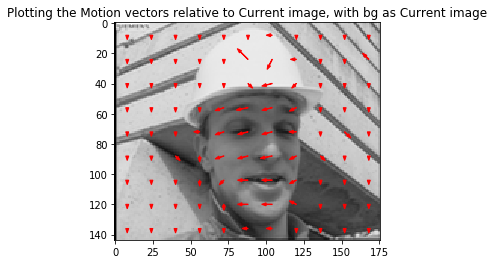

<Figure size 432x288 with 0 Axes>

In [8]:
### Plotting the MV : 
plot_MV(Curr,MV_rel,16,title = "Plotting the Motion vectors relative to Current image, with bg as Current image")

### Impletation 1.3  
#### Genereating the Motion compensated Predicted frame from the first image and MV matrix.

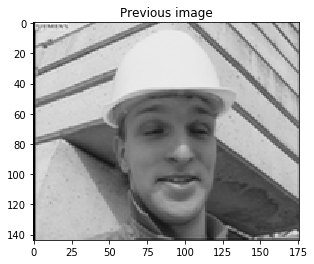

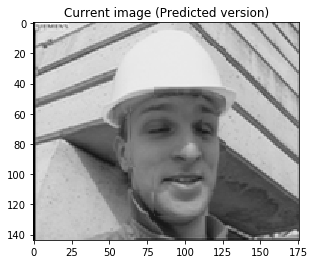

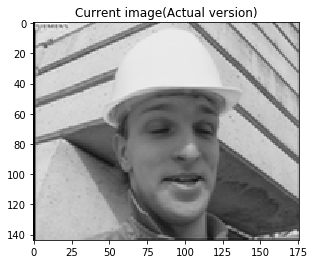

<Figure size 432x288 with 0 Axes>

In [9]:
C_c = create_MCPF(Prev,MV_abs,16)
image(img = Prev,plot = True,title = "Previous image")
image(img = C_c,plot = True,title = "Current image (Predicted version)")
image(img = Curr,plot = True, title = "Current image(Actual version)")


### 1.4 Computing and Visualising the error

The mean absolute error value b/w the predicted and actual image is 2.96 


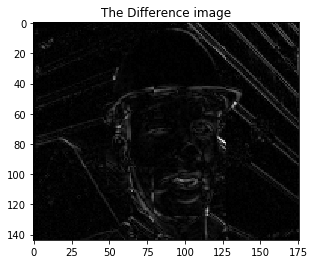

<Figure size 432x288 with 0 Axes>

In [10]:
Difference_img = abs(Curr - C_c)
v1 = Curr.reshape((Curr.shape[0]*Curr.shape[1],))
v2 = C_c.reshape((C_c.shape[0]*C_c.shape[1],))
error = MAD(v1,v2)

print('The mean absolute error value b/w the predicted and actual image is %.2f '%error)

image(img = Difference_img,plot = True, title = "The Difference image")


### THE END !!